## Imports and constants

In [1]:
%matplotlib inline

import os
import numpy as np
import scipy.stats as st
from scipy.optimize import curve_fit
from scipy import signal
import matplotlib.pyplot as plt

from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from onix.analysis.fitter import Fitter
from onix.helpers import data_identifier, console_bold, present_float

In [2]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [3]:
name = "Free Induction Decay"
analysis_number = None
identifier = None

In [4]:
def add_label(ax, x=0.02, y=1.1):
    ax.text(x, y, identifier, transform=ax.transAxes)

## Setup

In [26]:
data_numbers = [1388]
data, headers = get_experiment_data(data_numbers[0])
identifier = "data " + data_identifier(data_numbers)

In [27]:
headers

{'params': {'aom_channel': 2,
  'digitizer_channel': 0,
  'repeats': 1000,
  'excitation': {'frequency': 84 <Unit('megahertz')>,
   'amplitude': 2000,
   'time': 10 <Unit('millisecond')>},
  'coherence': {'frequency': 72 <Unit('megahertz')>,
   'amplitude': 1400,
   'time': 1 <Unit('millisecond')>},
  'yso': {'use': True,
   'eo_channel': 1,
   'frequency_excitation': 300 <Unit('megahertz')>,
   'frequency_coherence': 285 <Unit('megahertz')>,
   'eo_amplitude': 24000,
   'switch_ao_channel': 0,
   'switch_ao_frequency': 80 <Unit('megahertz')>,
   'switch_ao_amplitude_excitation': 250,
   'switch_ao_amplitude_coherence': 250}},
 'data_info': {'name': 'Free Induction Decay',
  'data_number': 1388,
  'save_time': '2023-10-23 20:41:08',
  'save_epoch_time': 1698108068.599583}}

## Overall plot

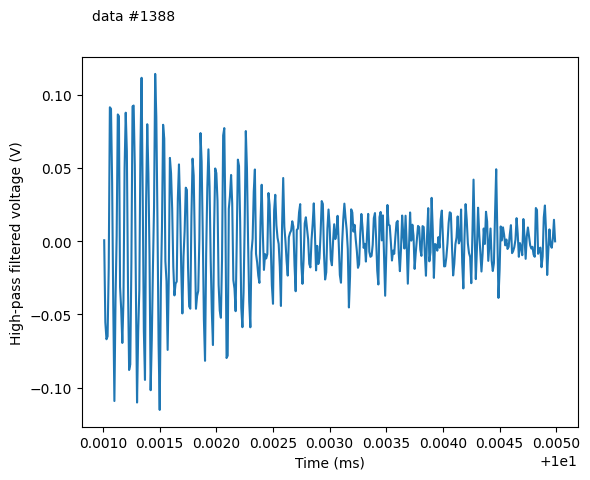

In [28]:
time_mask = np.bitwise_and(data["times"]>10.001e-03, data["times"]<10.005e-03)
fig, ax = plt.subplots()
add_label(ax)
ax.errorbar(data["times"][time_mask] * 1e3, butter_highpass_filter(np.average(data["voltages"], axis=0)[time_mask], 1e7, 1e8))
# ax.errorbar(data["times"] * 1e3, butter_highpass_filter(np.average(data["voltages"], axis=0), 1e7, 1e8))
ax.set_xlabel("Time (ms)")
ax.set_ylabel("High-pass filtered voltage (V)")
#ax.set_ylim(1.325, 1.375)
# ax.set_ylim(0.35, 0.45)
# ax.set_ylim(-0.1, 0.1)
#ax.set_xlim(10.001, 10.003)
# ax.set_ylim(-5.4, -3.5)
#ax.legend()
#plt.tight_layout()
#ax.set_xlim(20e-3, 21e-3)
plt.show()

In [29]:
np.savetxt("optical_fid_phase_pi.csv", np.transpose([data["times"][time_mask] * 1e3, butter_highpass_filter(np.average(data["voltages"], axis=0)[time_mask], 1e7, 1e8)]), delimiter=",")

In [175]:
butter_highpass_filter(np.average(data["voltages"], axis=0), 10, 1e8)

array([nan, nan, nan, ..., nan, nan, nan])

## Test data

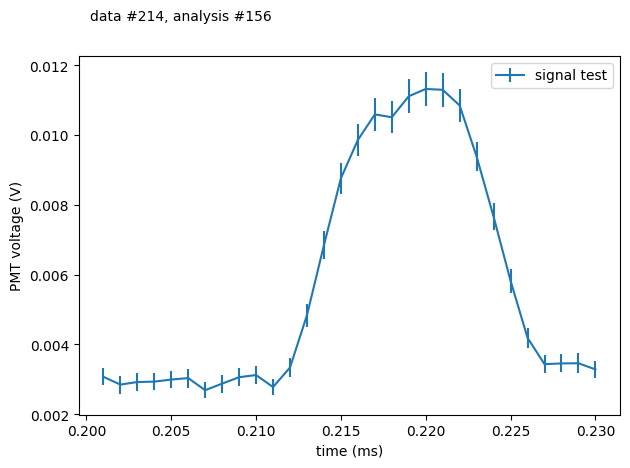

In [15]:
data.get_test_data()
fig, ax = plt.subplots()
add_label(ax)
ax.errorbar(data.test_times_ms, data.V_signal_test_avg, data.V_signal_test_err, label="signal test")
ax.set_xlabel("time (ms)")
ax.set_ylabel("PMT voltage (V)")
ax.legend()
plt.tight_layout()
plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + "_test.pdf"))
plt.show()

## decay data

In [16]:
def exp_decay(t, tau, a, c):
    return np.exp(-t / tau) * a + c

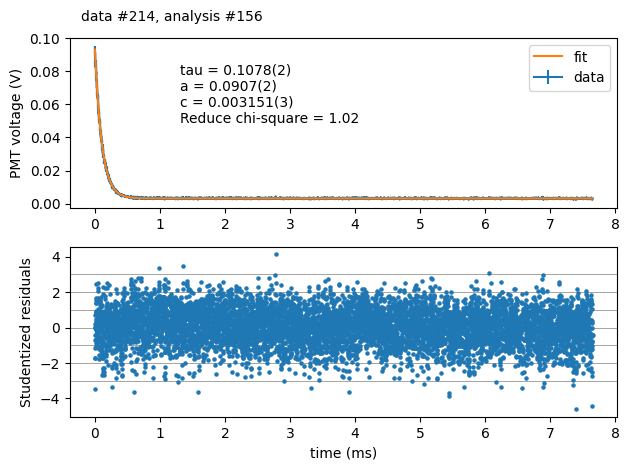

In [17]:
data.get_decay_data()

fitter = Fitter(exp_decay)
fitter.set_data(data.decay_times_ms, data.V_signal_decay_avg, data.V_signal_decay_err)
fitter.set_p0({"tau": 0.1, "a": 10, "c": 0})
fitter.fit()

fig, (ax, ax1) = plt.subplots(2, 1)

add_label(ax)
ax.errorbar(data.decay_times_ms, data.V_signal_decay_avg, data.V_signal_decay_err, label="data")
ax.plot(data.decay_times_ms, fitter.fitted_value(data.decay_times_ms), label="fit", zorder=50)
ax.text(0.2, 0.5, fitter.all_results_str(), transform=ax.transAxes)
ax.legend()

ax1.scatter(data.decay_times_ms, fitter.studentized_residuals(), s=5)
ax1.set_xlim(*ax.get_xlim())
ax1.use_sticky_edges = True
ax1.hlines([-3, -2, -1, 0, 1, 2, 3], *ax1.get_xlim(), zorder=0, color="grey", linewidth=0.5)
ax1.use_sticky_edges = False

ax1.set_xlabel("time (ms)")
ax1.set_ylabel("Studentized residuals")
ax.set_ylabel("PMT voltage (V)")


plt.tight_layout()
plt.savefig(get_analysis_file_path(analysis_number, str(analysis_number) + "_decay.pdf"))
plt.show()